# `unifhy` demo

In [1]:
import unifhy

## choose your components

A library of `unifhy`-compliant components available at https://github.com/unifhy-org

In [2]:
from unifhycontrib.artemis import SurfaceLayerComponent, SubSurfaceComponent

In [3]:
from unifhycontrib.rfm import OpenWaterComponent

In [4]:
print(SurfaceLayerComponent.__doc__)

Artemis provides a simple runoff production model designed to be
    comparable with the runoff-production models typically embedded
    within climate models.

    It is driven with precipitation, radiation,
    temperature, humidity and wind speed on a daily time step and
    calculates canopy interception, evaporation, snowmelt, infiltration,
    and runoff. It uses a Rutter–Gash canopy formulation (`Gash, 1979`_)
    to represent interception, together with Penman–Monteith evaporation
    calculated using available radiation data (`Monteith, 1965`_). Soil
    moisture is accounted for using a two-layer model with
    saturation-excess runoff computed using a generalized TOPMODEL
    (`Clark and Gedney, 2008`_). The snowpack is represented using a
    temperature-based model of accumulation and melt (`Moore et al.,
    1999`_, `Hock, 2003`_, `Beven, 2011`_). Snow accumulates when
    precipitation falls while temperature is below a threshold
    temperature. When temperature is abov

## create domains for space and time

### space

In [5]:
sd = unifhy.LatLonGrid.from_extent_and_resolution(
    latitude_extent=(50, 60),
    latitude_resolution=0.5,
    longitude_extent=(-11, 3),
    longitude_resolution=0.5
)

In [6]:
print(sd)

LatLonGrid(
    shape {Y, X}: (20, 28)
    Y, latitude (20,): [50.25, ..., 59.75] degrees_north
    X, longitude (28,): [-10.75, ..., 2.75] degrees_east
    Y_bounds (20, 2): [[50.0, ..., 60.0]] degrees_north
    X_bounds (28, 2): [[-11.0, ..., 3.0]] degrees_east
)


### time

In [7]:
from datetime import datetime, timedelta

In [8]:
td = unifhy.TimeDomain.from_start_end_step(
    start=datetime(2016, 1, 1, 0, 0, 0),
    end=datetime(2017, 1, 1, 0, 0, 0),
    step=timedelta(hours=1),
    calendar='gregorian'
)

In [9]:
print(td)

TimeDomain(
    time (8784,): [2016-01-01 00:00:00, ..., 2016-12-31 23:00:00] gregorian
    bounds (8784, 2): [[2016-01-01 00:00:00, ..., 2017-01-01 00:00:00]] gregorian
    calendar: gregorian
    units: seconds since 1970-01-01 00:00:00Z
    period: 366 days, 0:00:00
    timedelta: 1:00:00
)


## load datasets

### data for components

In [10]:
print(SurfaceLayerComponent.inputs_metadata)

air_temperature:
  kind: dynamic
  units: K
leaf_area_index:
  frequency: monthly
  kind: climatologic
  units: '1'
precipitation_flux:
  kind: dynamic
  units: kg m-2 s-1
specific_humidity:
  kind: dynamic
  units: '1'
surface_albedo:
  kind: static
  units: '1'
surface_downwelling_longwave_flux_in_air:
  kind: dynamic
  units: W m-2
surface_downwelling_shortwave_flux_in_air:
  kind: dynamic
  units: W m-2
vegetation_height:
  kind: static
  units: m
wind_speed:
  kind: dynamic
  units: m s-1



In [11]:
ds_sl = unifhy.DataSet(
    files=[
        '/data/demo-data/in/driving/LWdown_WFDE5_CRU_*_v1.1.nc',
        '/data/demo-data/in/driving/SWdown_WFDE5_CRU_*_v1.1.nc',
        '/data/demo-data/in/driving/Qair_WFDE5_CRU_*_v1.1.nc',
        '/data/demo-data/in/driving/Tair_WFDE5_CRU_*_v1.1.nc',
        '/data/demo-data/in/driving/Wind_WFDE5_CRU_*_v1.1.nc',
        '/data/demo-data/in/driving/Precip_WFDE5_CRU_*_v1.1.nc',
        '/data/demo-data/in/ancillary/leaf_area_index.nc',
        '/data/demo-data/in/ancillary/canopy_height.nc',
        '/data/demo-data/in/ancillary/soil_albedo.nc'
    ],
    name_mapping={
        'leaf-area index': 'leaf_area_index',
        'canopy height': 'vegetation_height',
        'soil albedo': 'surface_albedo'
    }
)

In [12]:
print(ds_sl)

DataSet{
    air_temperature(time(26304), latitude(20), longitude(28)) K
    leaf_area_index(time(12), latitude(360), longitude(720)) 1
    precipitation_flux(time(26304), latitude(20), longitude(28)) kg m-2 s-1
    specific_humidity(time(26304), latitude(20), longitude(28)) kg kg-1
    surface_albedo(latitude(360), longitude(720)) 1
    surface_downwelling_longwave_flux_in_air(time(26304), latitude(20), longitude(28)) W m-2
    surface_downwelling_shortwave_flux_in_air(time(26304), latitude(20), longitude(28)) W m-2
    vegetation_height(latitude(360), longitude(720)) m
    wind_speed(time(26304), latitude(20), longitude(28)) m s-1
}


In [13]:
print(SubSurfaceComponent.inputs_metadata)

saturated_hydraulic_conductivity:
  kind: static
  units: m s-1
topmodel_saturation_capacity:
  kind: static
  units: mm m-1
topographic_index:
  kind: static
  units: '1'



In [14]:
ds_ss = unifhy.DataSet(
    files=[
        '/data/demo-data/in/ancillary/saturated_hydraulic_conductivity.nc',
        '/data/demo-data/in/ancillary/available_water_storage_capacity.nc',
        '/data/demo-data/in/ancillary/topographic_index.nc'
    ],
    name_mapping={
        'saturated hydraulic conductivity': 'saturated_hydraulic_conductivity',
        'available water storage capacity': 'topmodel_saturation_capacity',
        'topographic index': 'topographic_index'
    }
)

In [15]:
print(OpenWaterComponent.inputs_metadata)

flow_accumulation:
  description: drainage area (specified in number of cells) draining to a grid box
  kind: static
  units: '1'



In [16]:
ds_ow = unifhy.DataSet(
    files='/data/demo-data/in/ancillary/rfm_iarea.nc',
    name_mapping={
        'RFM drainage area in cell counts (WFDEI)': 'flow_accumulation'
    }
)

### flow direction for spacedomain

In [17]:
print(
    SurfaceLayerComponent.requires_flow_direction(), 
    SubSurfaceComponent.requires_flow_direction(), 
    OpenWaterComponent.requires_flow_direction()
)

False False True


In [18]:
import cf

In [19]:
sd.flow_direction = cf.read('/data/demo-data/in/ancillary/flow_direction.nc')[0]

### land sea mask for spacedomain

In [20]:
print(
    SurfaceLayerComponent.requires_land_sea_mask(), 
    SubSurfaceComponent.requires_land_sea_mask(), 
    OpenWaterComponent.requires_land_sea_mask()
)

False False False


In [21]:
sd.land_sea_mask = cf.read('/data/demo-data/in/ancillary/land_sea_mask.nc')[0]

## configure your components

In [22]:
sl = SurfaceLayerComponent(
    saving_directory=f'/data/demo-data/out-{modeller}',
    timedomain=td,
    spacedomain=sd,
    dataset=ds_sl
)

In [23]:
ss = SubSurfaceComponent(
    saving_directory=f'/data/demo-data/out-{modeller}',
    timedomain=td,
    spacedomain=sd,
    dataset=ds_ss
)

In [24]:
print(OpenWaterComponent)

OpenWaterComponent(
    category: openwater
    inwards metadata:
        surface_runoff_flux_delivered_to_rivers [kg m-2 s-1]
        net_groundwater_flux_to_rivers [kg m-2 s-1]
    inputs metadata:
        flow_accumulation [1]
    requires land sea mask: False
    requires flow direction: True
    requires cell area: True
    parameters metadata:
        c_land [m s-1]
        cb_land [m s-1]
        c_river [m s-1]
        cb_river [m s-1]
        ret_l [1]
        ret_r [1]
        routing_length [m]
    constants metadata:
        a_thresh [1]
        rho_lw [kg m-3]
    states metadata:
        flow_in [m3]
        b_flow_in [m3]
        surf_store [m3]
        sub_store [m3]
    outputs metadata:
        outgoing_water_volume_transport_along_river_channel [m3 s-1]
)


In [25]:
ow = OpenWaterComponent(
    saving_directory=f'/data/demo-data/out-{modeller}',
    timedomain=td,
    spacedomain=sd,
    dataset=ds_ow,
    parameters={
        'c_land': (0.20, 'm s-1'),
        'cb_land': (0.10, 'm s-1'),
        'c_river': (0.62, 'm s-1'),
        'cb_river': (0.15, 'm s-1'),
        'ret_l': (0.0, '1'),
        'ret_r': (0.005, '1'),
        'routing_length': (50000, 'm')
    },
    constants={
        'a_thresh': (1, '1')
    },
    records={
        'outgoing_water_volume_transport_along_river_channel': {
            timedelta(days=1): ['mean']
        }
    }
)

## form a model from your components

In [26]:
model = unifhy.Model(
    identifier=run_identifier,
    config_directory=f'/data/demo-data/out-{modeller}',
    saving_directory=f'/data/demo-data/out-{modeller}',
    surfacelayer=sl,
    subsurface=ss,
    openwater=ow
)

## use your model

In [27]:
model.spin_up(
    start=datetime(2015, 1, 1, 0, 0, 0),
    end=datetime(2016, 1, 1, 0, 0, 0),
    cycles=1,
    dumping_frequency=timedelta(days=30)
)

In [28]:
model.simulate(dumping_frequency=timedelta(days=30))

## read your model outputs

In [29]:
flow = cf.read(f'/data/demo-data/out-{modeller}/{run_identifier}_openwater_run_records_daily.nc')[0]

In [30]:
import cfplot

In [31]:
%matplotlib inline

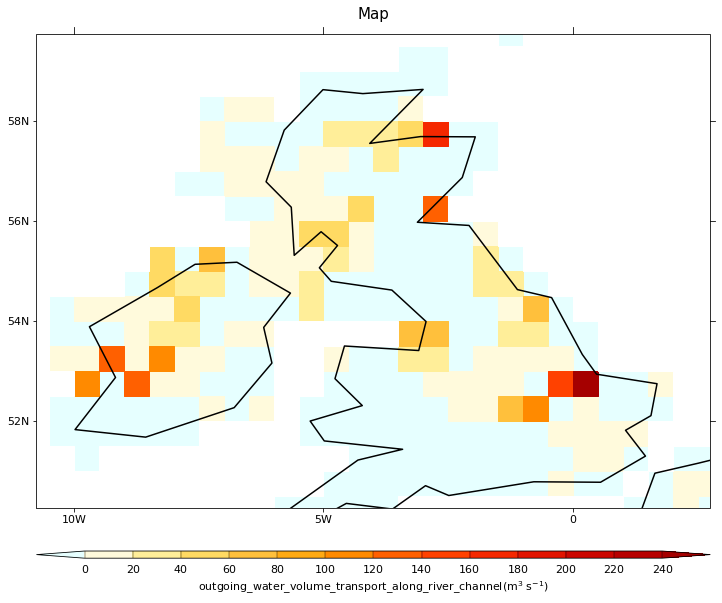

In [32]:
cfplot.con(flow[-1], blockfill=True, lines=False, title='Map')

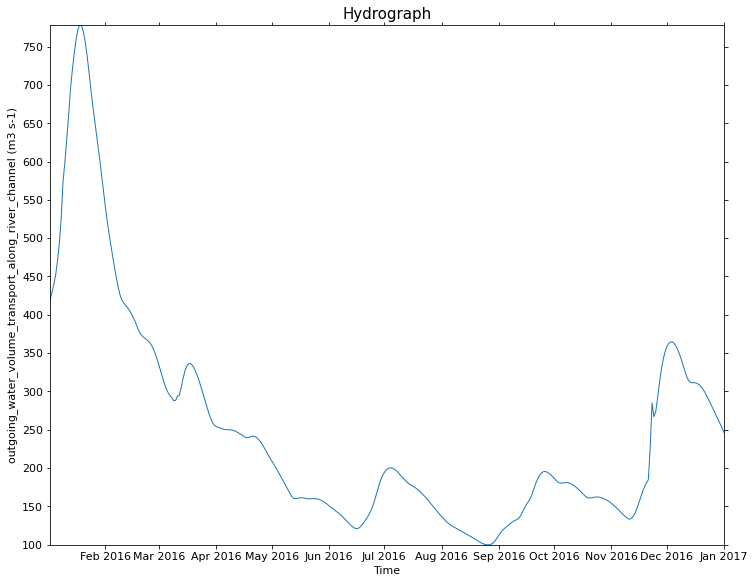

In [33]:
cfplot.lineplot(flow.subspace(Y=52.75, X=0.25), title='Hydrograph')

In [34]:
# close the output file
flow.close()